# Diabetes Risk Prediction

This notebook builds a machine learning pipeline to predict whether a patient is at risk for diabetes using the PIMA Indian dataset.

Goals:
- Perform EDA and handle missing/invalid values
- Build a strong preprocessing pipeline with feature engineering
- Compare multiple models (LogReg, RF, XGBoost, Neural Net)
- Visualize model performance (ROC, AUC, feature importance)
- Explain predictions with SHAP
- Train a Neural Network


In [26]:
!pip install scikit-learn xgboost shap matplotlib pandas seaborn joblib --quiet

## Exploratory Data Analysis

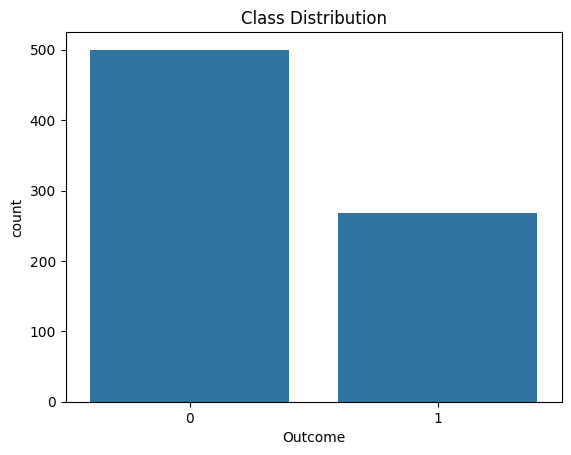

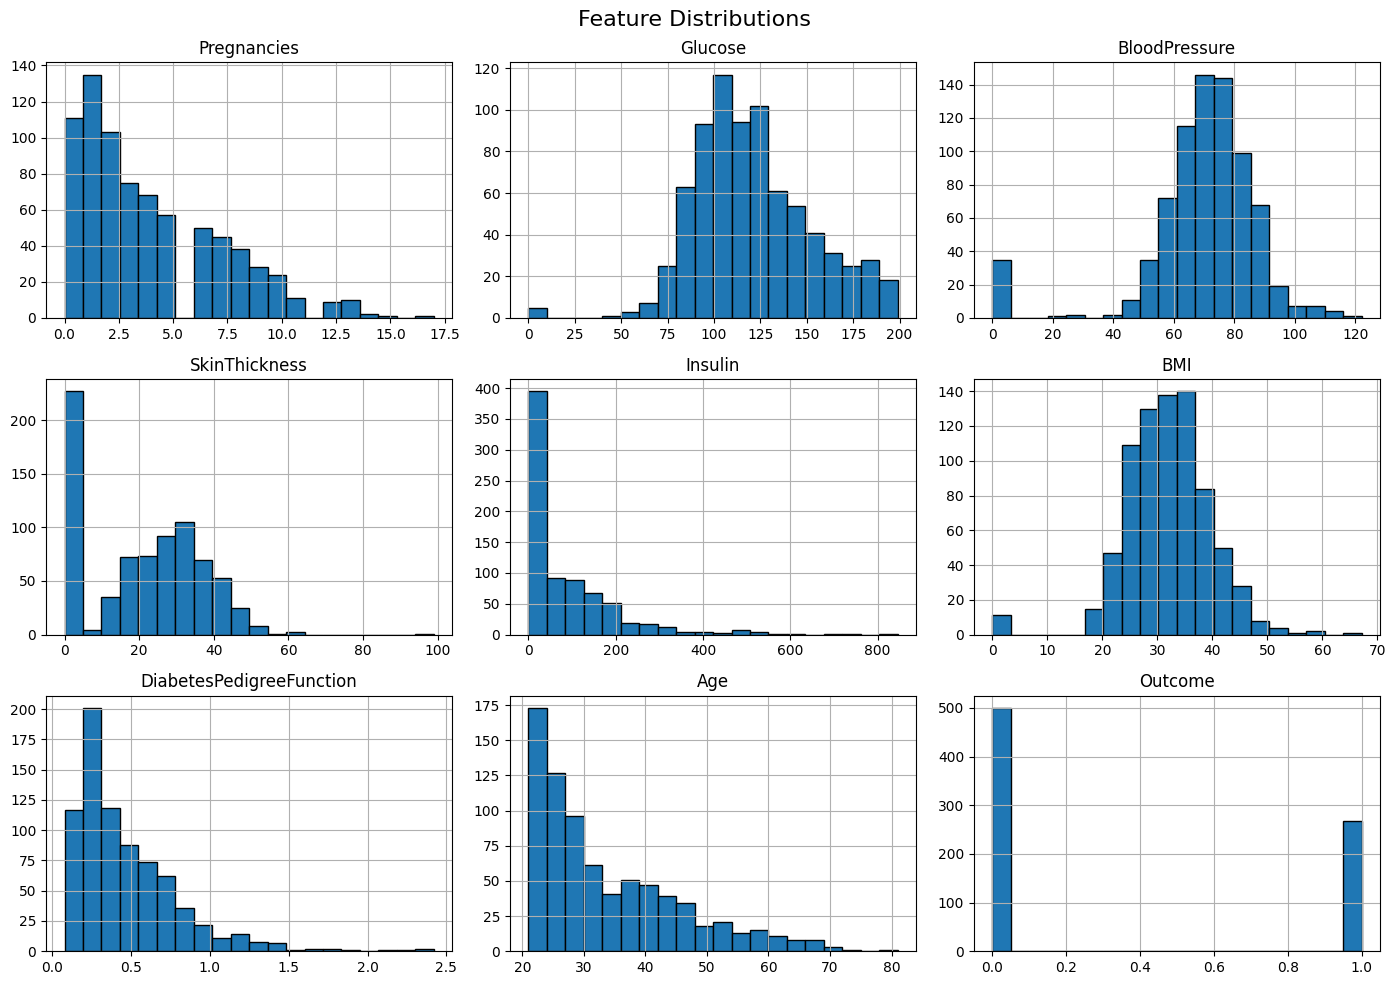

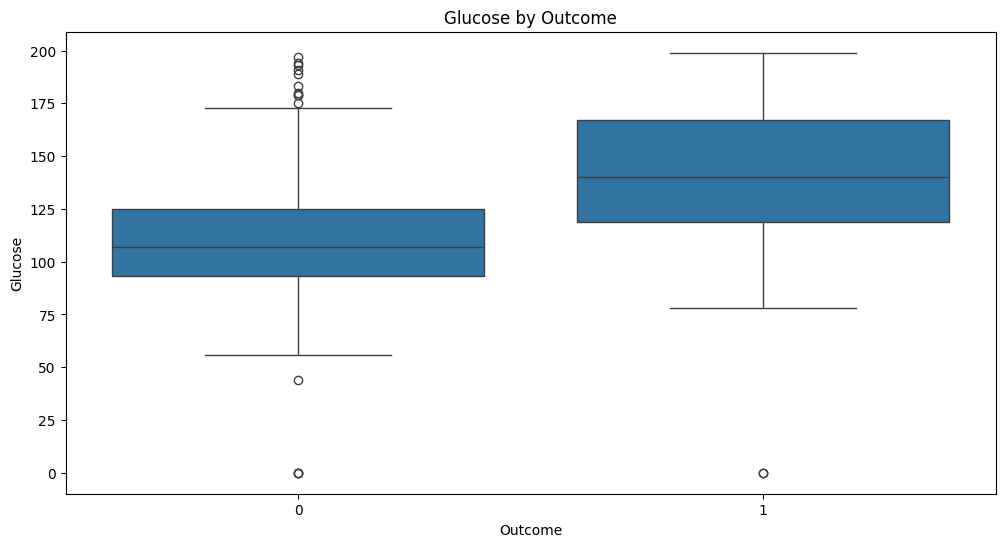

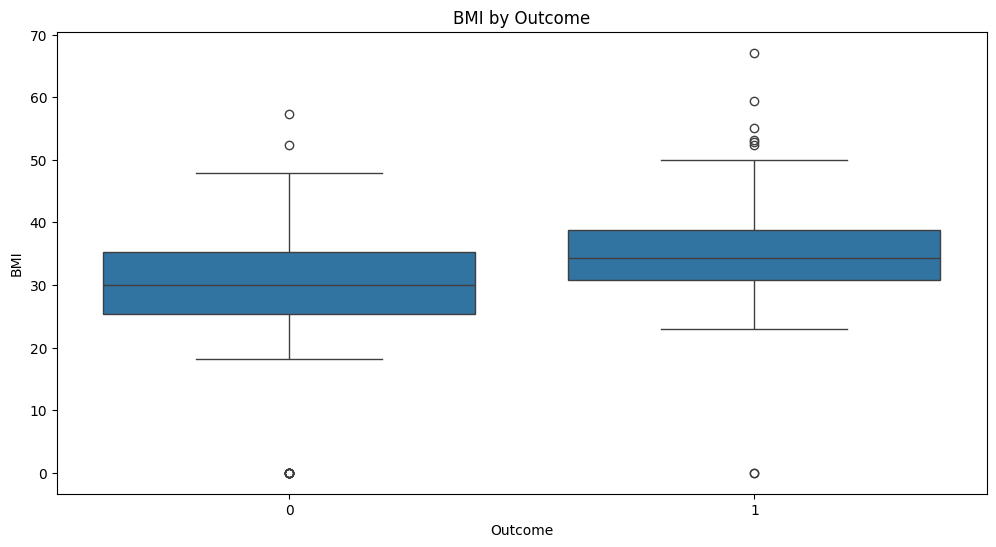

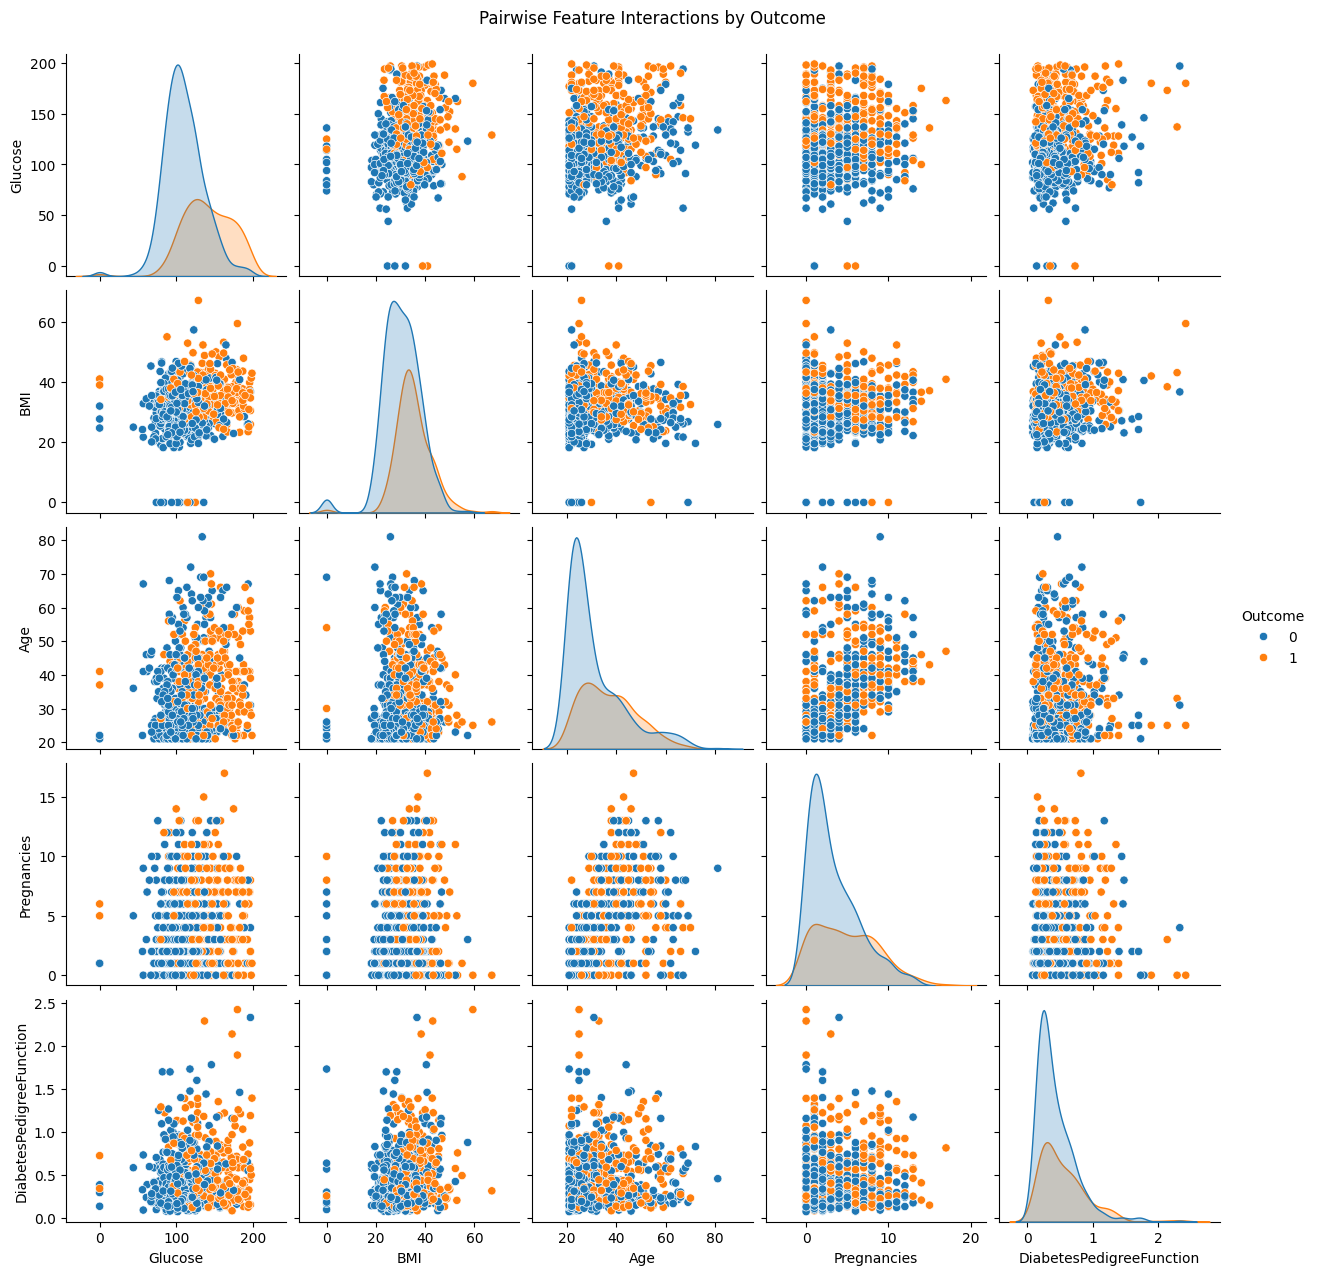

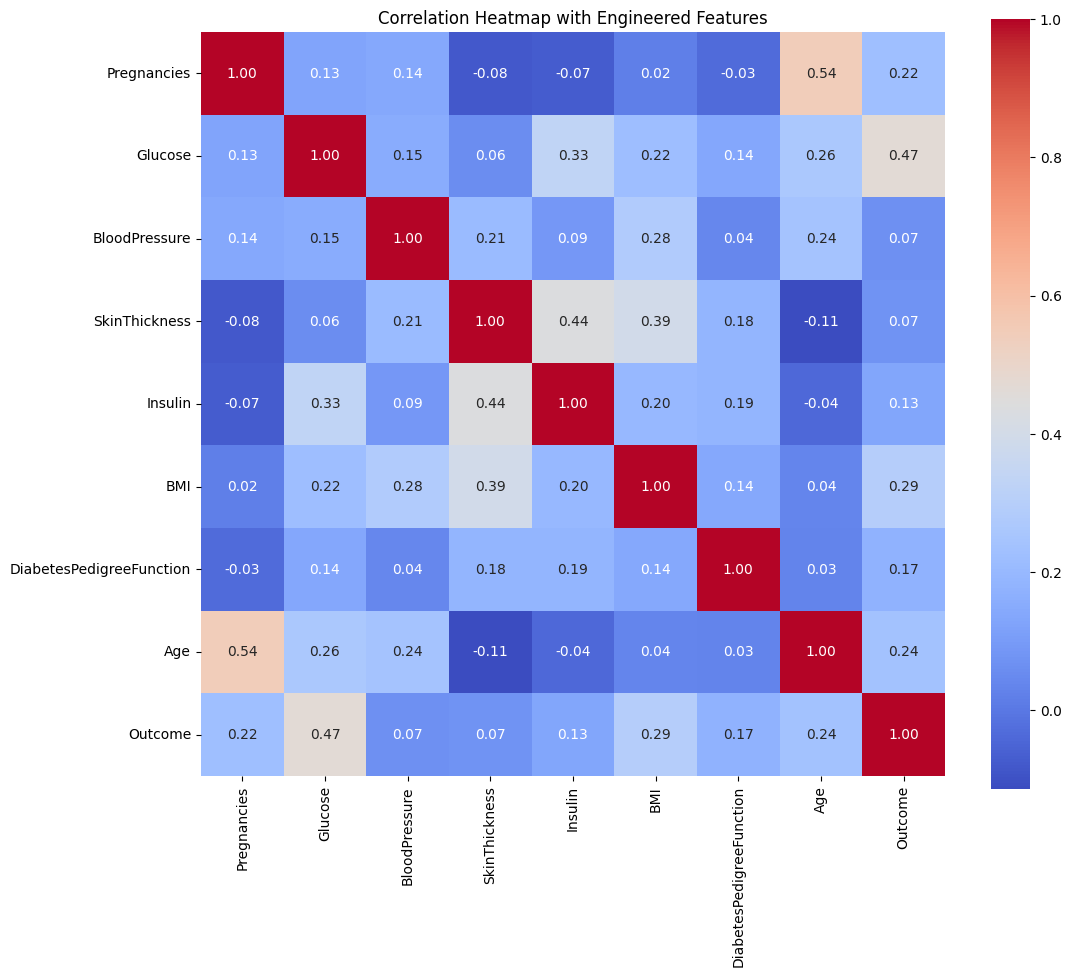

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
           "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
df = pd.read_csv(url, names=columns)

sns.countplot(data=df, x='Outcome')
plt.title("Class Distribution")
plt.show()


# Distribution of continuous variables
df.hist(figsize=(14, 10), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

# Boxplots to detect outliers and class differences
plt.figure(figsize=(12, 6))
sns.boxplot(x='Outcome', y='Glucose', data=df)
plt.title('Glucose by Outcome')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Outcome', y='BMI', data=df)
plt.title('BMI by Outcome')
plt.show()

# Pairplot for feature interaction by Outcome
selected_features = ["Glucose", "BMI", "Age", "Pregnancies", "DiabetesPedigreeFunction"]
sns.pairplot(df[selected_features + ["Outcome"]], hue="Outcome", diag_kind='kde')
plt.suptitle("Pairwise Feature Interactions by Outcome", y=1.02)
plt.show()

# Correlation heatmap with extended features
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap with Engineered Features")
plt.show()

## Feature Engineering and Preprocessing

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib

df_cleaned = df.copy()
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in zero_features:
    df_cleaned[col] = df_cleaned[col].replace(0, np.nan)
    df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)

df_cleaned["BMI_Age"] = df_cleaned["BMI"] * df_cleaned["Age"]
df_cleaned["GlucosePerPreg"] = df_cleaned["Glucose"] / (df_cleaned["Pregnancies"] + 1)
df_cleaned["LogInsulin"] = np.log1p(df_cleaned["Insulin"])
df_cleaned["LogBMI"] = np.log1p(df_cleaned["BMI"])

drop_cols = ["Insulin", "BMI"]
X = df_cleaned.drop(columns=["Outcome"] + drop_cols)
y = df_cleaned["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, "scaler.pkl")

/tmp/ipython-input-28-6493690.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)


['scaler.pkl']

## Train Machine Learning Models

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

predictions = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    predictions[name] = y_prob
    auc = roc_auc_score(y_test, y_prob)
    print(f"{name}: ROC AUC = {auc:.4f}")

joblib.dump(models["Random Forest"], "randomforest_model.pkl")

Logistic Regression: ROC AUC = 0.8233
Random Forest: ROC AUC = 0.8316


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:56:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost: ROC AUC = 0.7842


['randomforest_model.pkl']

## Random Search XG Boost and ROC Curve Comparison

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(50, 200),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 2)
}

random_search = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)
xgb_best = random_search.best_estimator_

y_prob_xg = xgb_best.predict_proba(X_test_scaled)[:, 1]
print("Tuned XGBoost ROC AUC:", roc_auc_score(y_test, y_prob))
joblib.dump(xgb_best, "xgboost_diabetes_model.pkl")


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:57:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Tuned XGBoost ROC AUC: 0.7842056932966024


['xgboost_diabetes_model.pkl']

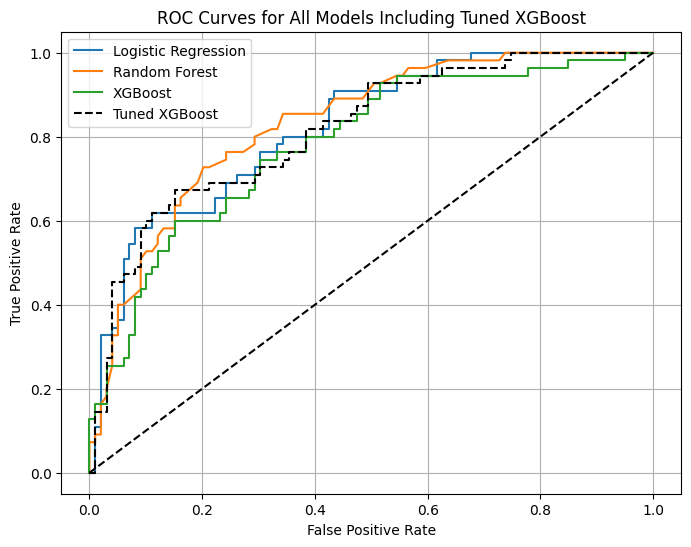

Logistic Regression: Precision = 0.6140, Recall = 0.6364
Random Forest: Precision = 0.6667, Recall = 0.6909
XGBoost: Precision = 0.5806, Recall = 0.6545
=== ROC AUC Scores ===
Logistic Regression: ROC AUC = 0.8233
Random Forest: ROC AUC = 0.8316
XGBoost: ROC AUC = 0.7842
Tuned XGBoost: ROC AUC = 0.8156


In [31]:
from sklearn.metrics import roc_curve, RocCurveDisplay, precision_score, recall_score

plt.figure(figsize=(8,6))
for name, y_prob in predictions.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name}")

# Add tuned XGBoost to the plot

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xg)
plt.plot(fpr_xgb, tpr_xgb, label="Tuned XGBoost", linestyle='--', color='black')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models Including Tuned XGBoost")
plt.legend()
plt.grid(True)
plt.show()

# Precision and recall for all models
for name, y_prob in predictions.items():
    y_pred = (y_prob > 0.5).astype(int)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(f"{name}: Precision = {precision:.4f}, Recall = {recall:.4f}")

# AUC Scores
print("=== ROC AUC Scores ===")
for name, y_prob in predictions.items():
    auc = roc_auc_score(y_test, y_prob)
    print(f"{name}: ROC AUC = {auc:.4f}")

auc_xgb = roc_auc_score(y_test, y_prob_xg)
print(f"Tuned XGBoost: ROC AUC = {auc_xgb:.4f}")
# Tuned XGBoost precision and recall
y_pred_labels_xgb = (y_pred_xgb > 0.5).astype(int)
precision_xgb = precision_score(y_test, y_pred_labels_xgb)
recall_xgb = recall_score(y_test, y_pred_labels_xgb)



## Explainability with SHAP

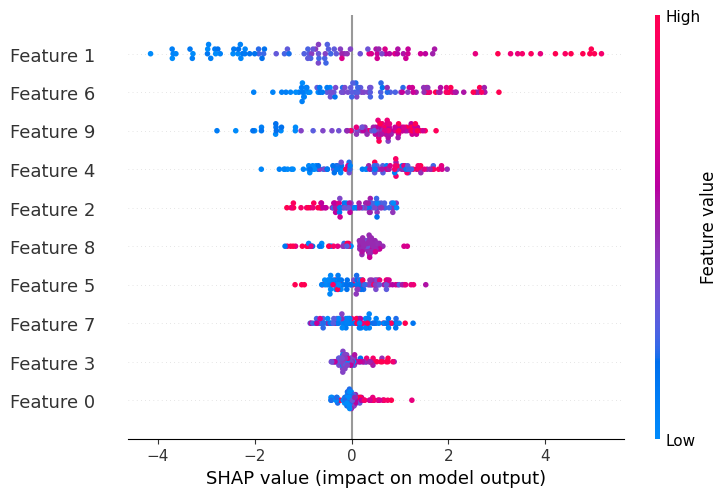

In [32]:
import shap
explainer = shap.Explainer(models["XGBoost"], X_train_scaled)
shap_values = explainer(X_test_scaled[:100])
shap.plots.beeswarm(shap_values)

## Neural Network Model (PyTorch)

In [33]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train_scaled.shape[1], 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.net(x)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dl = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

nn_model = MLP()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

for epoch in range(15):
    nn_model.train()
    total_loss = 0
    for xb, yb in train_dl:
        preds = nn_model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluation with ROC AUC
    nn_model.eval()
    with torch.no_grad():
        test_logits = nn_model(X_test_tensor)
        test_probs = torch.sigmoid(test_logits).numpy().flatten()
        test_labels = y_test_tensor.numpy().flatten()
        auc = roc_auc_score(test_labels, test_probs)

    print(f"Epoch {epoch+1}: Avg Loss = {total_loss / len(train_dl):.4f}, ROC AUC = {auc:.4f}")

Epoch 1: Avg Loss = 0.6771, ROC AUC = 0.7572
Epoch 2: Avg Loss = 0.6589, ROC AUC = 0.7822
Epoch 3: Avg Loss = 0.6351, ROC AUC = 0.7991
Epoch 4: Avg Loss = 0.5991, ROC AUC = 0.8105
Epoch 5: Avg Loss = 0.5453, ROC AUC = 0.8149
Epoch 6: Avg Loss = 0.5041, ROC AUC = 0.8167
Epoch 7: Avg Loss = 0.4694, ROC AUC = 0.8255
Epoch 8: Avg Loss = 0.4581, ROC AUC = 0.8255
Epoch 9: Avg Loss = 0.4450, ROC AUC = 0.8272
Epoch 10: Avg Loss = 0.4421, ROC AUC = 0.8305
Epoch 11: Avg Loss = 0.4357, ROC AUC = 0.8279
Epoch 12: Avg Loss = 0.4353, ROC AUC = 0.8312
Epoch 13: Avg Loss = 0.4263, ROC AUC = 0.8298
Epoch 14: Avg Loss = 0.4221, ROC AUC = 0.8323
Epoch 15: Avg Loss = 0.4223, ROC AUC = 0.8321
